# Medicare Clustering Analysis

Author: Kathleen Young

Date created: Wed Jan 17 22:04:04 2018

This notebook includes the code for a clustering analysis on the Medicare Provider Utilization and Payment dataset. The data is available [here](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Physician-and-Other-Supplier2015.html). For a more complete discussion of the results, please see my report Medicare_Clustering_Report.pdf.

### Import necessary packages

In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import collections as cl
import matplotlib
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

### Read the Medicare data

The data contains information on utilization, payment (allowed amount and Medicare payment), and submitted charges organized by National Provider Identifier (NPI), Healthcare Common Procedure Coding System (HCPCS) code, and place of service. For a full description of the data, see [here](https://www.cms.gov/Research-Statistics-Data-and-Systems/Statistics-Trends-and-Reports/Medicare-Provider-Charge-Data/Physician-and-Other-Supplier2015.html).

In [2]:
data = pd.read_csv("Medicare_Provider_Util_Payment_PUF_CY2015.txt", sep='\t')

C:\Users\kathleen.young.TREDENCE\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data exploration: histograms

Histograms for `average_Medicare_payment_amt` (the average amount that Medicare paid after deductible and coninsurance amounts have been deducted for the line item service) and `average_submitted_chrg_amt` (the average amount that Medicare paid after deductible).

The histograms of the original data are extremely right skewed for both variables. When the log is taken, both histograms appear to be fairly normal. For this reason, the log of the data is utilized later in the analysis.

`average_Medicare_payment_amt`

In [3]:
average_Medicare_payment_amt = data.average_Medicare_payment_amt.dropna(axis=0, how='any')

Text(0.5,1,'Average Medicare Payment Amount')

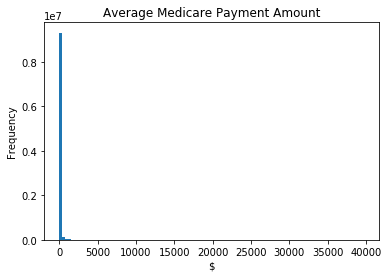

In [4]:
#hist of given data, ugly
plt.hist(average_Medicare_payment_amt, bins=100)
plt.xlabel('$'), plt.ylabel('Frequency')
plt.title('Average Medicare Payment Amount')

C:\Users\kathleen.young.TREDENCE\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0.5,1,'Log of Average Medicare Payment Amount')

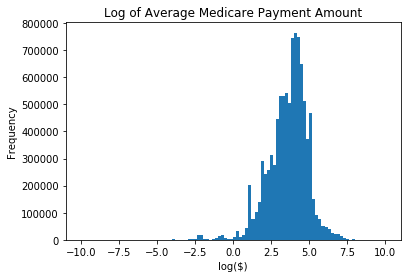

In [5]:
#log(), pretty, normal
plt.hist(np.log(average_Medicare_payment_amt), bins=100, range = (-10,10))
plt.xlabel('log($)'), plt.ylabel('Frequency')
plt.title('Log of Average Medicare Payment Amount')

`average_submitted_chrg_amt`

In [6]:
average_submitted_chrg_amt = data.average_submitted_chrg_amt.dropna(axis=0, how='any')

Text(0.5,1,'Average Submitted Charge Amount')

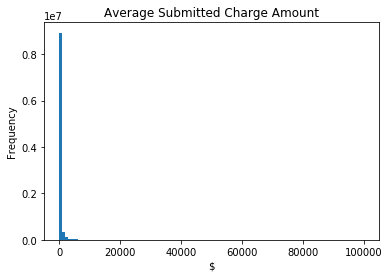

In [7]:
#hist of given data, ugly
plt.hist(average_submitted_chrg_amt, bins = 100)
plt.xlabel('$'), plt.ylabel('Frequency')
plt.title('Average Submitted Charge Amount')

Text(0.5,1,'Log of Average Submitted Charge Amount')

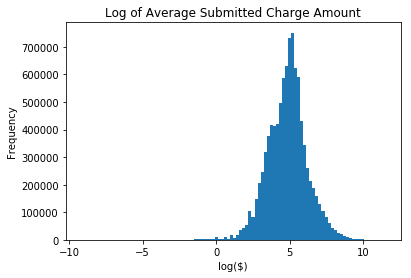

In [8]:
#log(), pretty, normal
plt.hist(np.log(average_submitted_chrg_amt), bins = 100)
plt.xlabel('log($)'), plt.ylabel('Frequency')
plt.title('Log of Average Submitted Charge Amount')

### Extract the four most common provider types

At this point in the exploratory data analysis, I wanted to examine the different types of provider types more closely. However, there were a prohibitive number of provider types, so I narrowed my analysis down to the top four most common provider types. This also help reduce the volume of data for the clustering process from 9.5 million entries to 3.8 million.

In [9]:
#Extracting the top 4 most common provider_types
provider_type = data.provider_type.dropna(axis=0, how='any')

#Find and print the distinct types
provider_types = set(list(provider_type))
#print(provider_types)

#Print the number of distinct types
print("Number of provider types:", len(list(provider_types)))

#Count and print the number of items belonging to each data type
cnt = cl.Counter(list(provider_type))
# print(cnt)

#Removing all other provider_types
top_4_practices = ['Diagnostic Radiology', 'Internal Medicine', 'Family Practice', 'Cardiology']
print("Top 4 practices: ", top_4_practices)
top_4_data = data[data.provider_type.isin(top_4_practices)]

print("Rows in original data: ", len(data))
print("Rows including only top 4 practices: ", len(top_4_data))

Number of provider types: 91
Top 4 practices:  ['Diagnostic Radiology', 'Internal Medicine', 'Family Practice', 'Cardiology']
Rows in original data:  9497892
Rows including only top 4 practices:  3824213


### Moving forward with `average_Medicare_payment_amt` and `average_submitted_chrg_amt`


After this exploratory analysis of the data, I decided to move forward with examining how the `average_Medicare_payment_amt` and `average_submitted_chrg_amt` related to each other. I wanted to see the average amount patients were being charged for medical services as well as how much Medicare was covering. I thought that the clusters might naturally fall into the `provider_type` categories mentioned above, and the analysis might reveal something about certain practices being are over- or under- covered.

Plot `average_Medicare_payment_amt` and `average_submitted_chrg_amt` for top 4 provider types

In [10]:
#Plotting average_Medicare_payment_amt and average_submitted_chrg_amt for top 4
average_submitted_chrg_amt_top_4 = top_4_data.average_submitted_chrg_amt.dropna(axis=0, how='any')
average_Medicare_payment_amt_top_4 = top_4_data.average_Medicare_payment_amt.dropna(axis=0, how='any')

Text(0.5,1,'Amount Medicare Paid VS Submitted Charge')

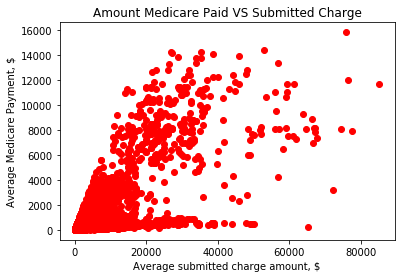

In [11]:
#Original data
plt.plot(average_submitted_chrg_amt_top_4, average_Medicare_payment_amt_top_4, 'ro')
plt.xlabel('Average submitted charge amount, $')
plt.ylabel('Average Medicare Payment, $')
plt.title('Amount Medicare Paid VS Submitted Charge')

C:\Users\kathleen.young.TREDENCE\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


Text(0.5,1,'Log of Amount Medicare Paid VS Log of Submitted Charge')

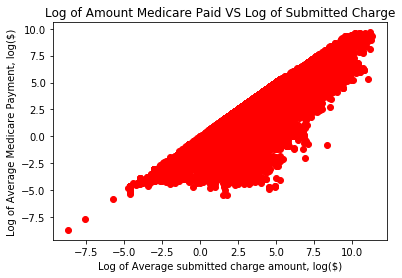

In [12]:
#Logged data
plt.plot(np.log(average_submitted_chrg_amt_top_4), np.log(average_Medicare_payment_amt_top_4), 'ro')
plt.xlabel('Log of Average submitted charge amount, log($)')
plt.ylabel('Log of Average Medicare Payment, log($)')
plt.title('Log of Amount Medicare Paid VS Log of Submitted Charge')

### Taking the log of everything for analysis

According to the histograms, the data is not normal. Thus, it is log transformed to make it normal and appropriate for analysis.

In [13]:
#Isolating the numeric columns
log_data = top_4_data[["average_submitted_chrg_amt",
                       "average_Medicare_payment_amt"]].dropna(axis=0, how="any")
#Taking the log
log_data = np.log(log_data)

#Adding the provider type back in for reference
log_data['provider_type'] = top_4_data.provider_type

#Dropping -inf and NA values from the dataframe caused by log and checking lengths
log_data = log_data[log_data != -np.inf]
print("Number of rows in data with -inf values: ", len(log_data))
log_data = log_data.dropna(axis=0, how="any")
print("Number of rows in data excluding -inf values: ", len(log_data))

Number of rows in data with -inf values:  3824213
Number of rows in data excluding -inf values:  3824187


### Plotting based on provider_type

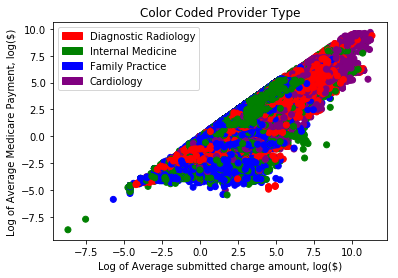

In [14]:
#Plotting with colors based on provider_type
provider_lst = list(log_data.provider_type)
colors = ['red','green','blue','purple']

#Ensuring they are the same length before plotting
#print(len(provider_lst))
#print(len(log_data.average_submitted_chrg_amt))

#Replacing strings with integer labels
provider_lst = [1 if x == "Diagnostic Radiology" else x for x in provider_lst]
provider_lst = [2 if x == "Internal Medicine" else x for x in provider_lst]
provider_lst = [3 if x == "Family Practice" else x for x in provider_lst]
provider_lst = [4 if x == "Cardiology" else x for x in provider_lst]

#Plotting and creating a legend
plt.scatter(log_data.average_submitted_chrg_amt, log_data.average_Medicare_payment_amt,
          c=provider_lst,cmap=matplotlib.colors.ListedColormap(colors))
plt.xlabel('Log of Average submitted charge amount, log($)')
plt.ylabel('Log of Average Medicare Payment, log($)')
plt.title('Color Coded Provider Type')
red_patch = matplotlib.patches.Patch(color='red', label='Diagnostic Radiology')
green_patch = matplotlib.patches.Patch(color='green', label='Internal Medicine')
blue_patch = matplotlib.patches.Patch(color='blue', label='Family Practice')
purple_patch = matplotlib.patches.Patch(color='purple', label='Cardiology')
plt.legend(handles=[red_patch, green_patch, blue_patch, purple_patch])
plt.show()

### Selecting the appropriate number of clusters

The k-means clustering algorithm was run nine times—once for each grouping of cluster, 2 through 10. A random seed was utilized in order to ensure repeatability. The absolute value of the “score” (objective value) of each cluster iteration was plotted against its number of clusters. This is the Scree plot—it shows where the benefit of adding more clusters tapers off via the objective value. Based on this plot, it appeared that the graph began to level out around 7 clusters. Thus, 7 clusters was chosen as the best number to move forward with.

In [15]:
#Isolate the numerical logged variables again
log_data = log_data[["average_submitted_chrg_amt","average_Medicare_payment_amt"]]

Using the k-means algorithm and computing objective score on...

In [16]:
#2 clusters
kmeans_2 = KMeans(n_clusters=2, random_state=1).fit(log_data)
score_2 = kmeans_2.score(log_data)
print("Objective score for two clusters = ", score_2)

Objective score for two clusters =  -4385003.587441122


In [17]:
#3 clusters
kmeans_3 = KMeans(n_clusters=3, random_state=1).fit(log_data)
score_3 = kmeans_3.score(log_data)
print("Objective score for three clusters = ", score_3)

Objective score for three clusters =  -3065594.8985974346


In [18]:
#4 clusters
kmeans_4 = KMeans(n_clusters=4, random_state=1).fit(log_data)
score_4 = kmeans_4.score(log_data)
print("Objective score for four clusters = ", score_4)

Objective score for four clusters =  -2167872.973179513


In [19]:
#5 clusters
kmeans_5 = KMeans(n_clusters=5, random_state=1).fit(log_data)
score_5 = kmeans_5.score(log_data)
print("Objective score for five clusters = ", score_5)

Objective score for five clusters =  -1790740.2718791654


In [20]:
#6 clusters
kmeans_6 = KMeans(n_clusters=6, random_state=1).fit(log_data)
score_6 = kmeans_6.score(log_data)
print("Objective score for six clusters = ", score_6)

Objective score for six clusters =  -1480645.1426632232


In [21]:
#7 clusters
kmeans_7 = KMeans(n_clusters=7, random_state=1).fit(log_data)
score_7 = kmeans_7.score(log_data)
print("Objective score for seven clusters = ", score_7)

Objective score for seven clusters =  -1249276.8534150526


In [22]:
#8 clusters
kmeans_8 = KMeans(n_clusters=8, random_state=1).fit(log_data)
score_8 = kmeans_8.score(log_data)
print("Objective score for eight clusters = ", score_8)

Objective score for eight clusters =  -1108798.0800991792


In [23]:
#9 clusters
kmeans_9 = KMeans(n_clusters=9, random_state=1).fit(log_data)
score_9 = kmeans_9.score(log_data)
print("Objective score for nine clusters = ", score_9)

Objective score for nine clusters =  -1005724.6850834008


In [24]:
#10 clusters
kmeans_10 = KMeans(n_clusters=10, random_state=1).fit(log_data)
score_10 = kmeans_10.score(log_data)
print("Objective score for nine clusters = ", score_10)

Objective score for nine clusters =  -909602.3127446009


Create a scree plot to pick the number of clusters

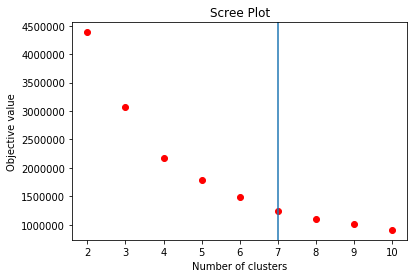

In [25]:
#Creating the scree plot
scores = np.array([abs(score_2), abs(score_3), abs(score_4), abs(score_5),
                   abs(score_6), abs(score_7), abs(score_8), abs(score_9),
                   abs(score_10)])
clusters = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.plot(clusters, scores, 'ro')
plt.xlabel('Number of clusters')
plt.ylabel('Objective value')
plt.title('Scree Plot')
plt.axvline(x=7)

It appears that kmeans_7 is the best choice! It will continue to be used for the rest of the analysis.

In [26]:
kmeans_7 = KMeans(n_clusters=7, random_state=1).fit(log_data)

### Plotting the clusters

Similar to the plot based on provider type from above, this is a 2D plot where points have a color based on cluster label for the algorithm run with seven clusters.

In [27]:
#Finding cluster labels and centroids
labels = kmeans_7.labels_
centroids = kmeans_7.cluster_centers_

#Turning the data into an array
log_data_array = np.array(log_data)

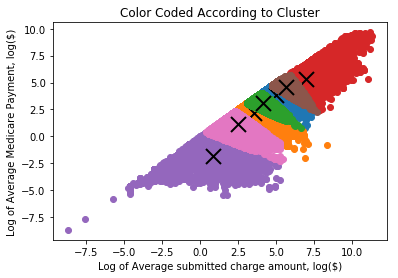

In [28]:
#Plotting the clusters based on color
for i in range(7):
    # select only data observations with cluster label == i
    ds = log_data_array[np.where(labels==i)]
    # plot the data observations
    plt.plot(ds[:,0],ds[:,1],'o')
    # plot the centroids
    lines = plt.plot(centroids[i,0],centroids[i,1],'kx')
    # make the centroid x's bigger
    plt.setp(lines,ms=15.0)
    plt.setp(lines,mew=2.0)
plt.xlabel('Log of Average submitted charge amount, log($)')
plt.ylabel('Log of Average Medicare Payment, log($)')
plt.title('Color Coded According to Cluster')
plt.show()

### Conclusion
It was posited that certain services are over- or under- covered by Medicare. The clustering plot above shows that the data is divided into clusters in which expensive treatments are covered more thoroughly than inexpensive treatments. It disconfirms the hypothesis that the points might naturally and clearly cluster based on service (diagnostic radiology, internal medicine, family practice, cardiology), which would show that different services are covered differently.

### Silhouettes and effectiveness of clustering

Silhouette plots demonstrate how appropriate each cluster was for each point. In order to run code on the silhouettes, the data set had to be parsed down considerably. A random sample of size 0.1% of the data set was used to create the silhouette values and plots. According to the average silhouette value, this clustering is mediocre at best. A value closer	to one would be preferable. The silhouette plots are also telling of this fact—though some of the clusters are large and reach well	over the red vertical line indicating the average, clusters	five, six, and especially four are thinner and don’t reach quite as	far	over the average line.

In [29]:
#Create a random sample of the data
sample_data = np.array(log_data.sample(frac=0.0001, random_state=10))

0.39032000090539715


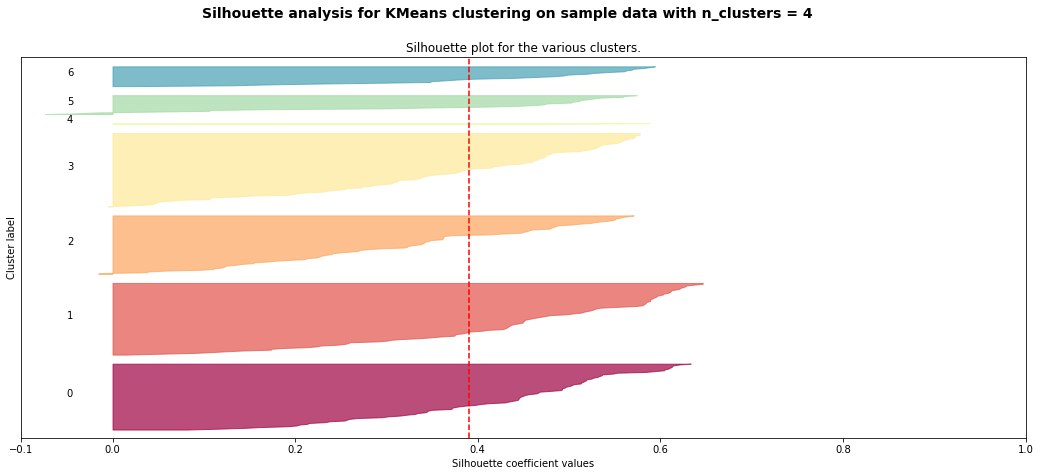

In [43]:
#Set up the plot
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(sample_data) + (7 + 1) * 10])

#Initialize the clusterer
clusterer = KMeans(n_clusters=7, random_state=10)
cluster_labels = clusterer.fit_predict(sample_data)

#Find the average silhouette value
silhouette_avg = silhouette_score(sample_data, cluster_labels)
print(silhouette_avg)

#Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(sample_data, cluster_labels)

#Create the silhouette plots
y_lower = 10
for i in range(7):
    #Aggregate the silhouette scores for samples belonging to
    #cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    #Create the colors
    cmap = cm.get_cmap("Spectral")
    color = cmap(float(i) / 7)
    ###color = cm.spectral(float(i) / 7)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    #Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    #Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples
    
#Label the silhouette plot
ax1.set_title("Silhouette plot for the various clusters.")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")

#Create a vertical line showing the average silhouette value
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

# Plot
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.suptitle(("Silhouette analysis for KMeans clustering on sample data with n_clusters = 4"),
                 fontsize=14, fontweight='bold')
plt.show()